# Basic experiment

# Make toy data

## Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0,I)
$$

## Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})
$$

In [1]:
import numpy as np

In [2]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

In [3]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

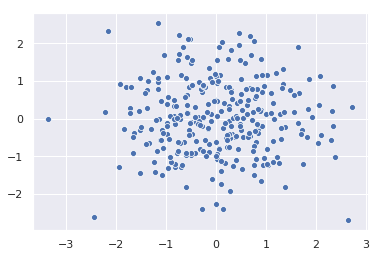

In [5]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

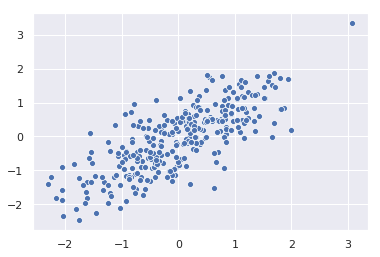

In [6]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

# Define MINE

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [8]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.selu(self.fc1(input))
        output = F.selu(self.fc2(output))
        output = self.fc3(output)
        return output

In [9]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    loss = -(torch.mean(t) - (et.mean()/ma_et.mean()).detach()*torch.log(torch.mean(et)))
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [10]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

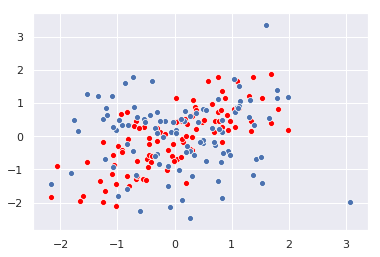

In [11]:
joint_data = sample_batch(y,batch_size=100,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0],y=joint_data[:,1],color='red')
marginal_data = sample_batch(y,batch_size=100,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,1])

In [12]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=1e+3):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [13]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [14]:
mine_net_indep = Mine().cuda()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-4)
result_indep = train(x,mine_net_indep,mine_net_optim_indep)

0.0013800993
-0.00047969367
0.00041664066
0.0009947118
-0.00011865649


0.00027126604


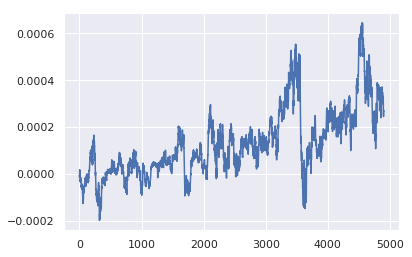

In [15]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
plt.plot(range(len(result_indep_ma)),result_indep_ma)

In [16]:
mine_net_cor = Mine().cuda()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-4)
result_cor = train(y,mine_net_cor,mine_net_optim_cor)

0.2114062
0.20342624
0.5953291
0.34102374
0.6026466


0.43450153


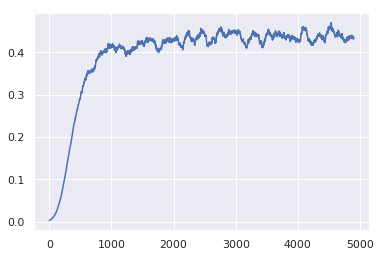

In [17]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)),result_cor_ma)

# Test with various correlations

In [18]:
correlations = np.linspace(-0.9,0.9,19)
print(correlations)

[-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9]


0.8892805
0.8577665
0.66276217
0.82905453
0.9593415
-0.9 : 0.853894
0.4650432
0.41301984
0.56925905
0.37823915
0.43979064
-0.8 : 0.53807724
0.4138726
0.27429798
0.33946508
0.2448689
0.27791977
-0.7 : 0.3817921
0.14552625
0.18054874
0.3241267
0.21985538
0.14978097
-0.6 : 0.18635826
0.004414387
0.10742393
0.119457215
0.20381963
0.112124816
-0.5 : 0.13127305
0.10105917
0.112626046
0.17011759
0.13071784
0.1195111
-0.4 : 0.11467435
0.045401108
0.041798428
0.06476699
0.087886766
-0.042766795
-0.29999999999999993 : 0.06934062
0.021058105
0.011124123
-0.007817972
0.035031274
0.040830977
-0.19999999999999996 : 0.04739675
-0.00053079927
-0.001003647
0.005733018
-0.013116433
0.009472905
-0.09999999999999998 : 0.008290487
-0.000121469755
0.0012472495
0.002473348
0.0029628817
0.004050123
0.0 : 0.002732547
0.0021134643
0.003649592
0.003346085
0.008904666
0.004305081
0.09999999999999998 : 0.002222047
0.028356258
0.024505194
-0.0026963893
-0.019864686
-0.01679806
0.20000000000000007 : 0.028608482
0.08

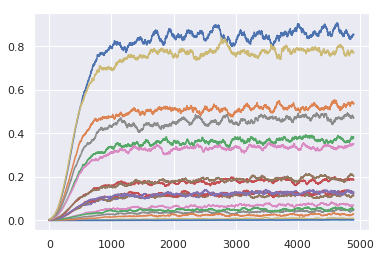

In [19]:
final_result = []
for rho in correlations:
    rho_data = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,rho],[rho,1]],
                                 size = 300)
    mine_net = Mine().cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-4)
    result = train(rho_data,mine_net,mine_net_optim)
    result_ma = ma(result)
    final_result.append(result_ma[-1])
    print(str(rho) + ' : ' + str(final_result[-1]))
    plt.plot(range(len(result_ma)),result_ma)

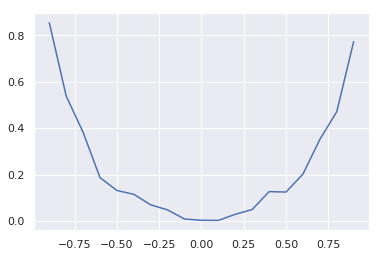

In [20]:
plt.plot(correlations, final_result)

# Equitability experiment

Check more information at [original equitability paper](http://www.pnas.org/content/pnas/111/9/3354.full.pdf).

# Make toy data

In [21]:
x = np.random.uniform(low=-1.,high=1.,size=3000)
f1 = x
f2 = 2*x
f3 = np.sin(x)
f4 = x**3
eps = np.random.normal(size=3000)

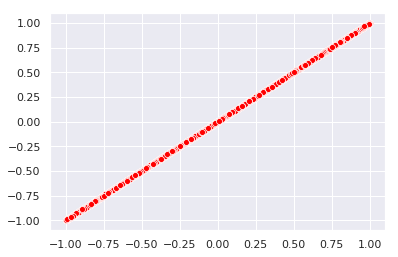

In [22]:
sns.scatterplot(x, f1,color='red')

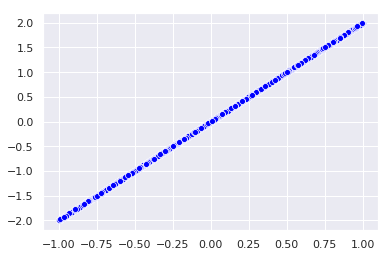

In [23]:
sns.scatterplot(x, f2,color='blue')

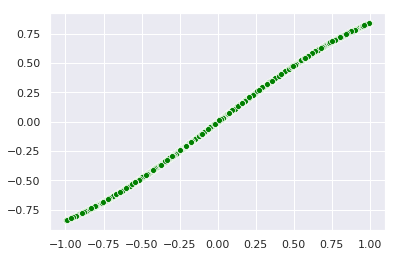

In [24]:
sns.scatterplot(x, f3,color='green')

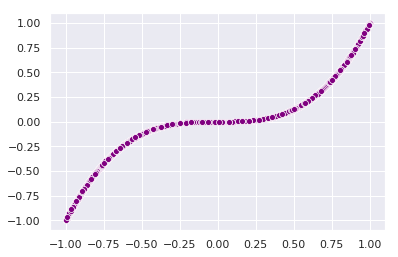

In [25]:
sns.scatterplot(x, f4,color='purple')

In [26]:
sigmas = np.linspace(0.0,0.9,10)
fs = [f1, f2, f3, f4]
print(sigmas)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


1.9073988
3.4118192
3.5306435
3.6029882
4.3269005
0.0,0 : 4.1177907
2.0361283
2.8648484
4.1972218
3.953223
3.783811
0.0,1 : 4.2976513
1.6258501
2.3104692
2.228757
2.6957898
2.5918336
0.0,2 : 2.9498289
0.7703747
0.95197
1.1471688
1.3052461
1.6020783
0.0,3 : 1.330135
1.3798972
1.4824262
1.884607
1.8033223
1.7394233
0.1,0 : 1.6229296
1.6483516
1.9650387
2.2948575
2.278719
2.2891169
0.1,1 : 2.2909677
1.0047843
1.4567904
1.4820137
1.4470756
1.4858234
0.1,2 : 1.4966562
0.6844572
0.89179856
0.5575537
0.87869287
0.9707304
0.1,3 : 0.85877615
0.7153796
1.1932473
1.0249674
1.0018499
0.98751175
0.2,0 : 1.0246627
1.4942725
1.4719169
1.1136401
1.3603518
1.8354003
0.2,1 : 1.6439755
0.780203
0.8744094
0.84462744
1.2525463
0.88542557
0.2,2 : 0.9257859
0.53049237
0.8324884
0.34028158
0.55849135
0.48679906
0.2,3 : 0.55114466
0.53419113
0.71160233
0.65229136
0.452125
0.6092105
0.30000000000000004,0 : 0.7098609
1.2111735
0.94200253
1.2406561
1.4036803
1.5969098
0.30000000000000004,1 : 1.2811368
0.5546076
0

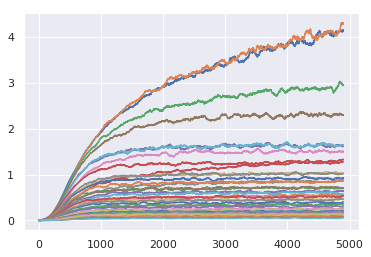

In [27]:
final_result = []
for sigma in sigmas:
    for fi, f in enumerate(fs):
        data = np.concatenate([x.reshape(-1,1), (f + sigma * eps).reshape(-1,1)], axis=1)
        mine_net = Mine().cuda()
        mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-4)
        result = train(data,mine_net,mine_net_optim,batch_size=100,iter_num=int(5e+3))
        result_ma = ma(result)
        final_result.append(result_ma[-1])
        print(str(sigma) + ',' + str(fi) +' : ' + str(final_result[-1]))
        plt.plot(range(len(result_ma)),result_ma)

In [28]:
re_final_result = np.transpose(np.array([final_result[4*i: 4*i+4]  for i in range(10)]))
print(re_final_result)

[[4.1177907  1.6229296  1.0246627  0.7098609  0.5189567  0.40564415
  0.2922484  0.22578153 0.19139794 0.15125743]
 [4.2976513  2.2909677  1.6439755  1.2811368  1.0249912  0.8812283
  0.70080423 0.5737706  0.5353588  0.4578469 ]
 [2.9498289  1.4966562  0.9257859  0.6362857  0.45407674 0.329212
  0.26693723 0.20913376 0.1575069  0.13536935]
 [1.330135   0.85877615 0.55114466 0.36878943 0.23474841 0.15649751
  0.12308732 0.08756919 0.07131957 0.05673064]]


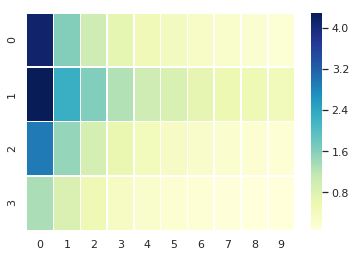

In [29]:
sns.heatmap(re_final_result,cmap="YlGnBu",linewidths=.5)